
Training SVM for qubit 1 using ZZ kernel...
Accuracy = 0.6995
Confusion matrix:
 [[1557  443]
 [ 759 1241]]


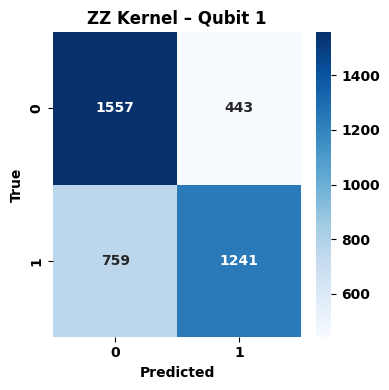

In [1]:
"""
This script implements a custom ZZ feature-map inspired kernel for SVM.
It loads the user's dataset (complex readouts of 4 qubits), converts them
to 8 real-valued IQ features, defines a tunable ZZ kernel, and trains an SVM
to classify one qubit's state (0/1). The gamma parameters of the kernel 
can be easily modified for experimentation.

Dataset format:
    X: 16000 × 4   (complex values)      <-- loaded as dtype=complex
    y: 16000 × 4   (bit labels)
"""

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# ================================================================
# 1) Load the dataset (fully compatible with your stored files)
# ================================================================
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    """
    Loads X as complex numbers (N,4) and labels y as integers (N,4).
    """
    X = np.loadtxt(X_path, dtype=complex)   # e.g. +1.23e-01+4.56e-01j
    y = np.loadtxt(y_path, dtype=int)
    return X, y


# ================================================================
# 2) Convert complex data → 8 real features
# ================================================================
def complex_to_features(X_complex):
    """
    Converts (N,4) complex array into (N,8) real feature matrix:
        [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
    """
    X_real = np.hstack([X_complex.real, X_complex.imag])
    return X_real


# ================================================================
# 3) Build the ZZ kernel (fully tunable)
# ================================================================
def make_zz_kernel(gamma_single=1.0, gamma_pair=1.0):
    """
    Returns a kernel function suitable for sklearn SVC:
        K(x,y) = prod_k cos( gamma_single * (x_k - y_k) )
                 × prod_{i<j} cos( gamma_pair * (x_i x_j - y_i y_j) )

    Inputs must be real-valued feature matrices of shape (N,8).
    """

    def zz_kernel(X, Y=None):
        X = np.asarray(X, float)
        if Y is None:
            Y = X
        else:
            Y = np.asarray(Y, float)

        nX, d = X.shape
        nY = Y.shape[0]

        # --- Single-qubit terms ---
        diff = X[:, None, :] - Y[None, :, :]        # shape (nX, nY, d)
        K_single = np.cos(gamma_single * diff).prod(axis=2)  # (nX, nY)

        # --- Pairwise ZZ terms ---
        K_pair = np.ones_like(K_single)
        for i in range(d):
            for j in range(i + 1, d):
                uX = X[:, i] * X[:, j]
                uY = Y[:, i] * Y[:, j]
                diff_pair = uX[:, None] - uY[None, :]
                K_pair *= np.cos(gamma_pair * diff_pair)

        return K_single * K_pair

    return zz_kernel

# ================================================================
# 4) Train SVM for a selected qubit index using ZZ kernel
# ================================================================
def train_svm_with_zz_kernel(qubit_index=0, gamma_single=0.8, gamma_pair=0.3):
    """
    Trains a binary classifier for qubit_index (0..3) using ZZ kernel.
    Allows tuning gamma_single and gamma_pair.
    """

    print(f"\nTraining SVM for qubit {qubit_index+1} using ZZ kernel...")

    # Load data
    X_complex, y_bits = load_dataset()

    # Convert complex → 8 real features
    X = complex_to_features(X_complex)
    y = y_bits[:, qubit_index]

    # Build kernel
    zz_kernel = make_zz_kernel(gamma_single=gamma_single,
                               gamma_pair=gamma_pair)

    # Use pipeline: scaling + SVM
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel=zz_kernel, C=1.0))
    ])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                         random_state=42, stratify=y)

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy = {acc:.4f}")
    print("Confusion matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1"], yticklabels=["0","1"])
    plt.title(f"ZZ Kernel – Qubit {qubit_index+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return model, acc, cm

# ================================================================
# 5) Example run
# ================================================================
if __name__ == "__main__":
    model, acc, cm = train_svm_with_zz_kernel(
        qubit_index=0,
        gamma_single=0.8,
        gamma_pair=0.3
    )
